# Orbit Fitting

In [1]:
import warnings 
warnings.filterwarnings('ignore')
from IPython import display
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from scipy.optimize import minimize
from scipy.interpolate import UnivariateSpline, InterpolatedUnivariateSpline
import sys
sys.path.append('../code/')
import fit_perturber as fp
import make_plots as mp


import gala.coordinates as gc
import gala.potential as gp
import gala.dynamics as gd
from gala.dynamics import mockstream as ms
from gala.units import galactic
from gala.dynamics.nbody import DirectNBody

import astropy.coordinates as coord
import astropy.units as u
from astropy.io import fits
from pyia import GaiaData
from sklearn.neighbors import KernelDensity

#%matplotlib notebook
%matplotlib inline

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

from sklearn.mixture import GaussianMixture
import pymc3 as pm
import pymc3_ext as pmx
import theano.tensor as tt

import emcee
import tqdm
from contextlib import closing
from multiprocessing import Pool
import scipy
import importlib

import corner

In [2]:
def plot_pretty(dpi=175, fontsize=15, labelsize=15, figsize=(10, 8), tex=True):
    # import pyplot and set some parameters to make plots prettier
    plt.rc('savefig', dpi=dpi)
    plt.rc('text', usetex=tex)
    plt.rc('font', size=fontsize)
    plt.rc('xtick.major', pad=1)
    plt.rc('xtick.minor', pad=1)
    plt.rc('ytick.major', pad=1)
    plt.rc('ytick.minor', pad=1)
    plt.rc('figure', figsize=figsize)
    mpl.rcParams['xtick.labelsize'] = labelsize
    mpl.rcParams['ytick.labelsize'] = labelsize
    mpl.rcParams.update({'figure.autolayout': False})
    
plot_pretty(fontsize=15, labelsize=15)

In [3]:
phi1_stream_pm_model = np.load('../data/phi1_stream_from_pm_model.npy')
stream_pm10 = np.load('../data/true_pm1_from_model.npy')
spline_pm1 = InterpolatedUnivariateSpline(phi1_stream_pm_model[::10], stream_pm10[::10])
stream_pm20 = np.load('../data/true_pm2_from_model.npy')
spline_pm2 = InterpolatedUnivariateSpline(phi1_stream_pm_model[::10], stream_pm20[::10])

est_track = np.load('../data/gd1_track.npy')
spline_phi2 = UnivariateSpline(phi1_stream_pm_model.reshape(est_track.shape)[::10], 
                                           est_track[::10])

sections = np.arange(-100,15,5)
dm = np.concatenate([[14.7, 14.6, 14.5, 14.45, 14.4, 14.35, 14.3, 14.3], 
                     np.linspace(14.3, 14.6, 9), 
                     [14.71, 14.75, 14.8, 15, 15.2, 15.4]])

spline_dm = UnivariateSpline(sections, dm, k=5)

rv_bonaca_data = fits.open('../data/rv_catalog.fits')[1].data
gd1_rv_bonaca = rv_bonaca_data[rv_bonaca_data.pmmem & rv_bonaca_data.cmdmem & 
                               rv_bonaca_data.vrmem & rv_bonaca_data.fehmem]
gd1_rv_bonaca = gd1_rv_bonaca[gd1_rv_bonaca.phi1.argsort()]

spline_rv_bon = UnivariateSpline(gd1_rv_bonaca.phi1, gd1_rv_bonaca.Vrad, k=1, s = np.inf)


after = GaiaData('../data/member_prob_all.fits')
model_output = after[after.post_member_prob > 0.3]

phi1s = np.linspace(-100, 20, 120)

In [4]:
d = GaiaData('../data/gd1_ps1_with_basic_masks_thin.fits')
d.data

source_id,ra,dec,parallax,parallax_error,pmra,pmra_error,pmdec,pmdec_error,ra_parallax_corr,ra_pmra_corr,ra_pmdec_corr,dec_parallax_corr,dec_pmra_corr,dec_pmdec_corr,parallax_pmra_corr,parallax_pmdec_corr,pmra_pmdec_corr,visibility_periods_used,phot_g_mean_mag,phot_g_mean_flux_over_error,phot_bp_mean_mag,phot_bp_mean_flux_over_error,phot_rp_mean_mag,phot_rp_mean_flux_over_error,phot_bp_rp_excess_factor,astrometric_chi2_al,astrometric_n_good_obs_al,objID,raMean,decMean,nDetections,ng,nr,ni,nz,ny,gMeanPSFMag,rMeanPSFMag,iMeanPSFMag,zMeanPSFMag,yMeanPSFMag,gMeanPSFMagErr,rMeanPSFMagErr,iMeanPSFMagErr,zMeanPSFMagErr,yMeanPSFMagErr,sep_arcsec,g_0,r_0,i_0,z_0,y_0,pm_mask,gi_cmd_mask,phi1,phi2,pm_phi1_cosphi2,pm_phi2
,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,mas / yr,mas / yr
int64,float64,float64,float64,float32,float64,float32,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,float32,float32,float32,float32,float32,float32,float32,float32,int16,int64,float64,float64,int16,int16,int16,int16,int16,int16,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bool,bool,float64,float64,float64,float64
5707499168266668800,124.34609344941018,-19.671996509666215,0.23908933289662254,0.04781023,-1.627045407691012,0.038337678,2.8751249034893087,0.03121912,0.07823116,-0.11784272,-0.3454113,-0.17714737,-0.38285083,0.2695398,0.3717254,-0.24432613,-0.048542865,22,16.420189,2603.0925,16.666891,329.28018,16.014679,453.14197,1.1893414,584.6626,626,84391243461223933,124.34609539,-19.67199988,80,15,12,24,16,13,16.679800033569336,16.439800262451172,16.354000091552734,16.372600555419922,16.342599868774414,0.0042050001211464405,0.004137000069022179,0.0024840000551193953,0.003889000043272972,0.004776000045239925,0.013801799122398739,16.36138352751732,16.21182930469513,16.185155004262924,16.239893540740013,16.233482979238033,False,False,-99.99998974953799,-9.401555369237643,1.7582442210609377,2.7968191266080042
5714940594243874304,121.03587868896385,-17.94366574903224,0.3223769865071406,0.04870918,-1.9342358955251646,0.046989128,1.5216671309550585,0.03897202,0.05235888,0.075656734,-0.0011952525,-0.14225459,-0.0056617153,0.13800927,0.17716475,-0.24963076,0.23984396,23,16.452152,2206.7917,16.709862,284.7805,16.033773,357.34232,1.1908067,418.0782,443,86461210358997957,121.03588016,-17.94366566,69,10,11,18,18,12,16.717100143432617,16.457500457763672,16.391599655151367,16.3976993560791,16.38719940185547,0.00240899994969368,0.0031109999399632215,0.001227000029757619,0.002572000026702881,0.006430000066757202,0.005048330236075074,16.411197811365128,16.238489046692848,16.229390397667885,16.27020789682865,16.282370947301388,False,False,-99.99998957904452,-5.823224474521122,0.375918811171435,2.432164551112767
3033393083142608384,112.88255235331313,-13.308166225300512,0.4189088151454519,0.21147743,-1.877598028147927,0.18968292,1.1090892820321105,0.18528558,0.122827046,-0.14800596,-0.0108461995,-0.23020032,0.023805281,0.30020782,0.14028092,-0.36037052,-0.17216381,18,18.754494,552.16736,19.24033,32.00037,18.16211,76.3716,1.1899724,325.30243,290,92031128825700538,112.88255253,-13.3081657,47,8,5,11,12,11,19.290800094604492,18.77519989013672,18.507699966430664,18.383699417114258,18.310100555419922,0.009987999685108662,0.023274000734090805,0.008224000222980976,0.01140000019222498,0.01875000074505806,0.001989809338192472,18.18799066543579,17.985641181468964,17.92291885614395,17.924079567193985,17.932183176279068,False,True,-99.99998750084802,3.2922805742688688,-0.03947501399742496,2.180342889025948
3033603231584491136,112.49763946230448,-13.077150305570827,0.4405096706458771,0.43537453,-0.7079983338854163,0.35308954,0.7660376569719846,0.3184226,0.28291208,-0.24630846,-0.14432156,-0.3279706,-0.030186914,0.13491932,0.11588298,-0.39469993,0.010195083,18,19.773771,300.8951,20.64357,14.675906,19.054615,35.72886,1.1418444,306.32825,319,923011249765677

In [5]:
# average error on pm_phi1 which we then use for the bandwidth
print(np.sqrt(np.mean(model_output.pm_cov[:, 1,1])))
# average error on pm_phi2 which we then use for the bandwidth
print(np.sqrt(np.mean(model_output.pm_cov[:, 0,0])))

0.28496430801564243
0.2101877274949474


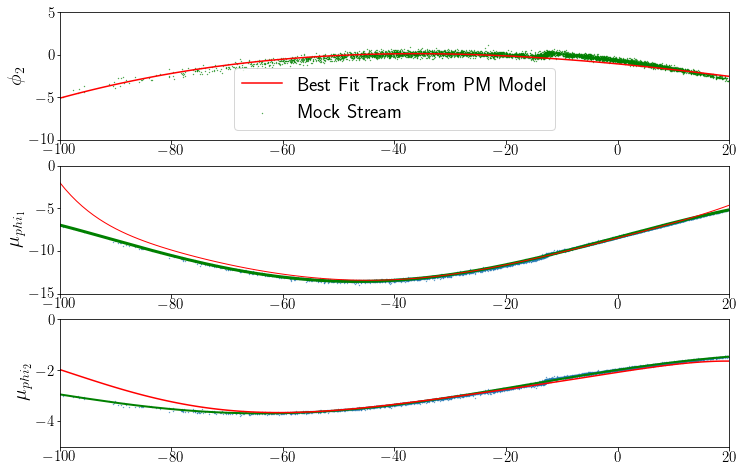

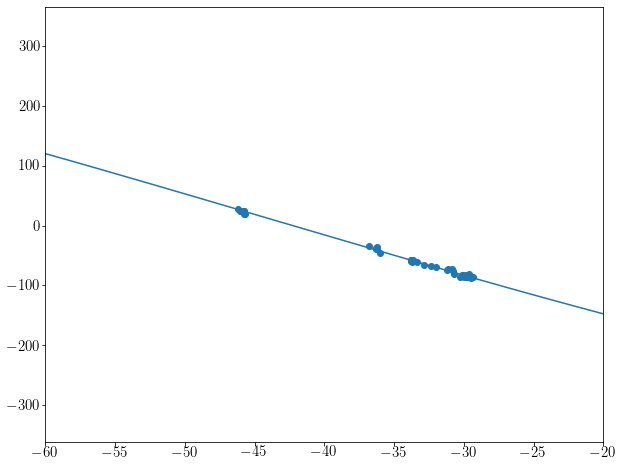

In [53]:
# my top choice and the one to use for the spur modeling
#creates the gaps around -20 and -5
df = ms.FardalStreamDF(random_state=np.random.RandomState(42))
#gd1_init = gc.GD1Koposov10(phi1 = -13*u.degree, phi2=-0.2*u.degree, distance=8.73*u.kpc,
#                      pm_phi1_cosphi2=-10.6*u.mas/u.yr,
#                      pm_phi2=-2.52*u.mas/u.yr,
#                     radial_velocity = -185*u.km/u.s)
gd1_init = gc.GD1Koposov10(phi1 = -13*u.degree, phi2=0*u.degree, distance=8.836*u.kpc,
                                  pm_phi1_cosphi2=-10.575*u.mas/u.yr,
                                  pm_phi2=-2.439*u.mas/u.yr,
                                  radial_velocity = -189.6*u.km/u.s)
rep = gd1_init.transform_to(coord.Galactocentric).data
gd1_w0 = gd.PhaseSpacePosition(rep)
gd1_mass = 5e3 * u.Msun
gd1_pot = gp.PlummerPotential(m=gd1_mass, b=5*u.pc, units=galactic)
mw = gp.MilkyWayPotential(halo={'m': 5.35e11*u.Msun, 'r_s': 15.27*u.kpc})
gen_gd1 = ms.MockStreamGenerator(df, mw, progenitor_potential=gd1_pot)
gd1_stream, gd1_nbody = gen_gd1.run(gd1_w0, gd1_mass,
                                dt=-1 * u.Myr, n_steps=3000)
gd1 = gd1_stream.to_coord_frame(gc.GD1)
sorted_gd1 = gd1[gd1.phi1.argsort()]

spline_pm10 = UnivariateSpline(sorted_gd1.phi1, sorted_gd1.pm_phi1_cosphi2, k=5)
spline_pm20 = UnivariateSpline(sorted_gd1.phi1, sorted_gd1.pm_phi2, k=5)
spline_rv = UnivariateSpline(sorted_gd1.phi1, sorted_gd1.radial_velocity)
spline_dist = UnivariateSpline(sorted_gd1.phi1, sorted_gd1.distance)

fig, (ax1, ax2, ax3) = plt.subplots(3,1, figsize=(12,8))
ax1.scatter(gd1.phi1.value, gd1.phi2.value, s=0.1, c='g', label='Mock Stream')
ax1.plot(phi1s, spline_phi2(phi1s), c='r', label='Best Fit Track From PM Model')
ax1.set_xlim(-100,20)
ax1.set_ylim(-10, 5)
ax1.set_ylabel(r'$\phi_2$')
ax1.legend()

ax2.scatter(gd1.phi1, gd1.pm_phi1_cosphi2, s=0.1)
ax2.plot(sorted_gd1.phi1, spline_pm10(sorted_gd1.phi1), c='g', lw=3)
ax2.plot(phi1s, spline_pm1(phi1s), c='r', lw=1)
ax2.set_xlim(-100,20)
ax2.set_ylim(-15,0)
ax2.set_ylabel(r'$\mu_{phi_1}$')

ax3.scatter(gd1.phi1, gd1.pm_phi2, s=0.1)
ax3.plot(sorted_gd1.phi1, spline_pm20(sorted_gd1.phi1), c='g', lw=2)
ax3.plot(phi1s, spline_pm2(phi1s), c='r')
ax3.set_xlim(-100,20)
ax3.set_ylim(-5,0)
ax3.set_ylabel(r'$\mu_{phi_2}$')
#(halo={'m': np.exp(lnM)}

plt.figure()
rv_bonaca_data = fits.open('../data/rv_catalog.fits')[1].data
gd1_rv_bonaca = rv_bonaca_data[rv_bonaca_data.pmmem & rv_bonaca_data.cmdmem & rv_bonaca_data.vrmem 
                               & rv_bonaca_data.fehmem]

plt.scatter(gd1_rv_bonaca.phi1, gd1_rv_bonaca.Vrad)
plt.plot(phi1s, spline_rv(phi1s))
plt.xlim(-60, -20)
plt.show()

In [8]:
#fix mass, fine grid in t, optimize for velocity
#maybe start with course grid by fixing t_int

gd1_short = gd1_stream[(-68<gd1.phi1.value) & (gd1.phi1.value<-24)]
w0_now = gd.PhaseSpacePosition(gd1_short.data, gd1_short.vel)

after = GaiaData('../data/member_prob_all.fits')
model_output = after[after.post_member_prob > 0.3]

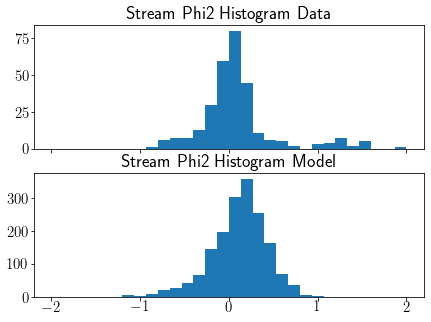

In [11]:
data_window = model_output[(model_output.phi1[:,0] > -60) & (model_output.phi1[:,0] < -22)]
gd1_window = gd1[(gd1.phi1.value > -60) & (gd1.phi1.value < -25)]
fig, (ax1, ax2) = plt.subplots(2, 1, figsize = (7,5), sharex = True)
ax1.hist(data_window.phi2, bins = 30, range=(-2, 2))
ax1.set_title('Stream Phi2 Histogram Data')
ax2.hist(gd1_window.phi2.value, bins = 30, range=(-2,2))
ax2.set_title('Stream Phi2 Histogram Model')
plt.show()

In [39]:
from astropy.table import Table
data = Table.read('../data/full_table8.fits')
data

b,psi,z,v_z,v_psi,t,logm,logprob_model,logprob_data,model_dens_ratio,pert_apo,pert_peri
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
10.0,120.0,0.0,230.0,190.0,320.0,6.6,--,--,--,--,--
1.0,45.0,0.4,230.0,190.0,60.0,6.6,--,--,--,--,--
1.0,45.0,0.4,230.0,190.0,80.0,6.6,--,--,--,--,--
1.0,45.0,0.4,230.0,190.0,80.0,6.4,--,--,--,--,--
1.0,45.0,0.4,230.0,190.0,80.0,6.2,--,--,--,--,--
1.0,45.0,0.4,230.0,190.0,80.0,6.0,--,--,--,--,--
1.0,45.0,0.4,230.0,190.0,80.0,5.8,--,--,--,--,--
1.0,45.0,0.4,230.0,190.0,70.0,6.8,--,--,--,--,--
1.0,45.0,0.4,230.0,190.0,70.0,6.6,--,--,--,--,--


In [40]:
data = data[data['pert_apo'] < 500]
data

b,psi,z,v_z,v_psi,t,logm,logprob_model,logprob_data,model_dens_ratio,pert_apo,pert_peri
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
1.0,0.0,0.0,170.0,10.0,820.0,6.2,-1547.01,-3919.86,0.94,172.67,14.5
5.0,345.0,0.0,190.0,20.0,810.0,6.4,-1549.58,-3323.03,0.83,286.4,14.26
5.0,0.0,0.0,170.0,10.0,820.0,6.2,-1552.69,-4915.54,0.97,172.67,14.5
5.0,0.0,0.0,210.0,20.0,820.0,6.4,-1552.96,-4806.03,0.91,495.33,14.58
5.0,345.0,0.0,190.0,10.0,820.0,6.2,-1553.38,-5732.82,1.0,267.26,14.5
10.0,0.0,0.0,170.0,10.0,820.0,6.2,-1553.98,-4602.72,0.95,172.66,14.5
5.0,0.0,0.0,170.0,20.0,820.0,6.4,-1554.07,-7102.46,0.79,173.82,14.58
1.0,0.0,0.0,150.0,10.0,820.0,6.2,-1554.09,-4787.98,0.91,121.74,14.49
1.0,0.0,0.0,190.0,10.0,820.0,6.2,-1554.44,-3820.51,1.08,267.32,14.51


In [41]:
# take the top 10000 to examine their distributions
top_data = data[:10000]
cut_data = data[data['model_dens_ratio'] < 0.75]
top_cut_data = cut_data[:10000]

In [80]:
np.flip(top_data[top_data.argsort('logprob_data')])

array([( 1., 210., 0.4, 190.,  40., 1060., 6.2, -1585.84,  -2697.1 , 1.33, 154.27, 19.76),
       ( 1.,   0., 0.4, 190.,  20.,  800., 6.4, -1598.2 ,  -2746.92, 0.38, 298.09, 14.03),
       (10., 210., 0. , 210.,  30., 1060., 6. , -1586.28,  -2748.59, 1.66, 218.36, 19.62),
       ...,
       (10., 180., 0.4, 150.,  70.,  670., 6.2, -1592.8 , -27268.13, 0.97,  90.62, 20.31),
       (50., 105., 0. , 210.,  20.,  130., 6. , -1595.9 , -27441.96, 1.81, 213.99, 19.39),
       ( 5.,   0., 0.4, 170., 140.,  900., 6.2, -1596.17, -34623.08, 0.91, 167.08, 19.84)],
      dtype=[('b', '<f8'), ('psi', '<f8'), ('z', '<f8'), ('v_z', '<f8'), ('v_psi', '<f8'), ('t', '<f8'), ('logm', '<f8'), ('logprob_model', '<f8'), ('logprob_data', '<f8'), ('model_dens_ratio', '<f8'), ('pert_apo', '<f8'), ('pert_peri', '<f8')])

In [11]:
for i in range(len(top_data)):
    if top_data[i]['psi'] > 180:
        top_data[i]['psi'] -= 360
        
for i in range(len(top_cut_data)):
    if top_cut_data[i]['psi'] > 180:
        top_cut_data[i]['psi'] -= 360

In [21]:
for_corner = np.empty((0,7))
for i in top_data:
    for_corner = np.append(for_corner, [np.array(list(i)[:-5])], axis=0)

 b    psi   z   v_z  v_psi   t   logm logprob_model logprob_data model_dens_ratio pert_apo pert_peri
---- ----- --- ----- ----- ----- ---- ------------- ------------ ---------------- -------- ---------
 1.0   0.0 0.0 170.0  10.0 820.0  6.2      -1547.01     -3919.86             0.94   172.67      14.5
 5.0 345.0 0.0 190.0  20.0 810.0  6.4      -1549.58     -3323.03             0.83    286.4     14.26
 1.0   0.0 0.0 210.0  10.0 810.0  6.4      -1552.05     -3753.87             0.66   538.71     14.23
 5.0   0.0 0.0 170.0  10.0 820.0  6.2      -1552.69     -4915.54             0.97   172.67      14.5
 5.0   0.0 0.0 210.0  20.0 820.0  6.4      -1552.96     -4806.03             0.91   495.33     14.58
 5.0 345.0 0.0 190.0  10.0 820.0  6.2      -1553.38     -5732.82              1.0   267.26      14.5
10.0   0.0 0.0 170.0  10.0 820.0  6.2      -1553.98     -4602.72             0.95   172.66      14.5
 5.0   0.0 0.0 170.0  20.0 820.0  6.4      -1554.07     -7102.46             0.79   173.82 

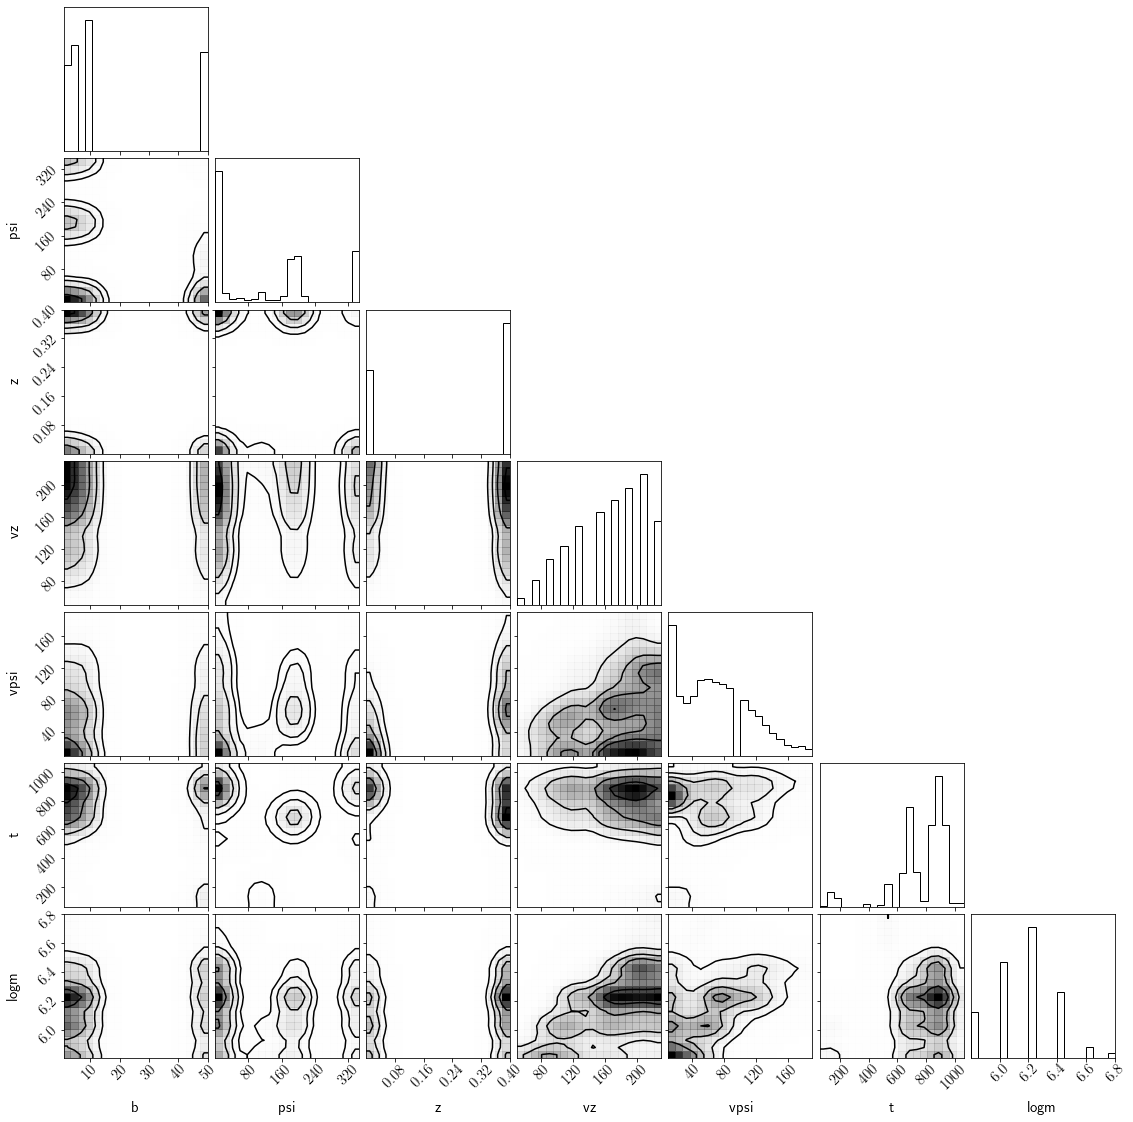

In [22]:
#non-weighted points, gap non-mandated
print(top_data[:10])
corner.corner(for_corner, labels=(r'b', r'psi', r'z', r'vz', r'vpsi', r't', r'logm'), smooth = 1.5,
             plot_datapoints = False)
plt.show()

 b  psi  z   v_z  v_psi   t   logm logprob_model logprob_data model_dens_ratio pert_apo pert_peri
--- --- --- ----- ----- ----- ---- ------------- ------------ ---------------- -------- ---------
1.0 0.0 0.0 170.0  10.0 820.0  6.2      -1547.01     -3919.86             0.94   172.67      14.5


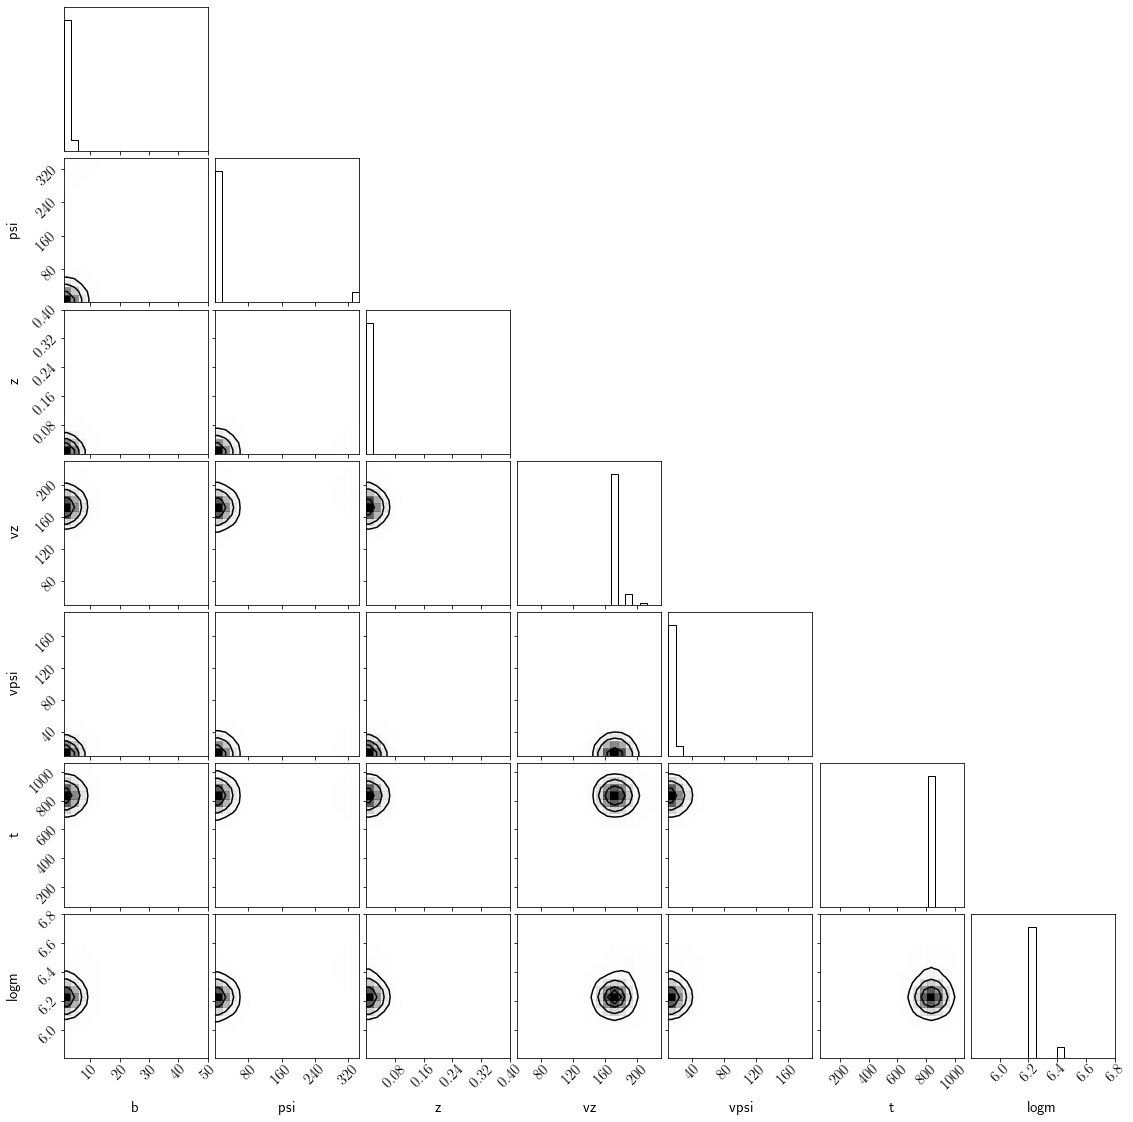

In [23]:
#weighted points, gap non-mandated
print(top_data[0])
corner.corner(for_corner, labels=(r'b', r'psi', r'z', r'vz', r'vpsi', r't', r'logm'), 
              weights = np.exp(top_data['logprob_model'] - top_data['logprob_model'].max()),
              smooth = 1.5, plot_datapoints = False)
plt.show()

In [24]:
for_corner_cut = np.empty((0,7))
for i in top_cut_data:
    for_corner_cut = np.append(for_corner_cut, [np.array(list(i)[:-5])], axis=0)

 b    psi   z   v_z  v_psi   t   logm logprob_model logprob_data model_dens_ratio pert_apo pert_peri
---- ----- --- ----- ----- ----- ---- ------------- ------------ ---------------- -------- ---------
 1.0   0.0 0.0 210.0  10.0 810.0  6.4      -1552.05     -3753.87             0.66   538.71     14.23
 5.0 345.0 0.0 210.0  10.0 810.0  6.4      -1557.88     -3585.26             0.64    538.5     14.23
 5.0   0.0 0.0 210.0  10.0 820.0  6.4      -1558.23     -5464.28             0.73   489.38     14.51
 1.0   0.0 0.0 210.0  10.0 820.0  6.4      -1558.59     -4909.35             0.73    489.4     14.51
10.0   0.0 0.0 130.0  10.0 810.0  6.4      -1558.92     -5131.38             0.44    93.05     14.21
10.0   0.0 0.0  90.0  10.0 810.0  6.2      -1559.67     -5831.11             0.53    56.13      14.2
 5.0   0.0 0.0 130.0  10.0 810.0  6.4      -1560.31     -6192.14             0.39    93.05     14.21
 1.0   0.0 0.0 170.0  10.0 810.0  6.4      -1560.48     -4355.11             0.48   180.39 

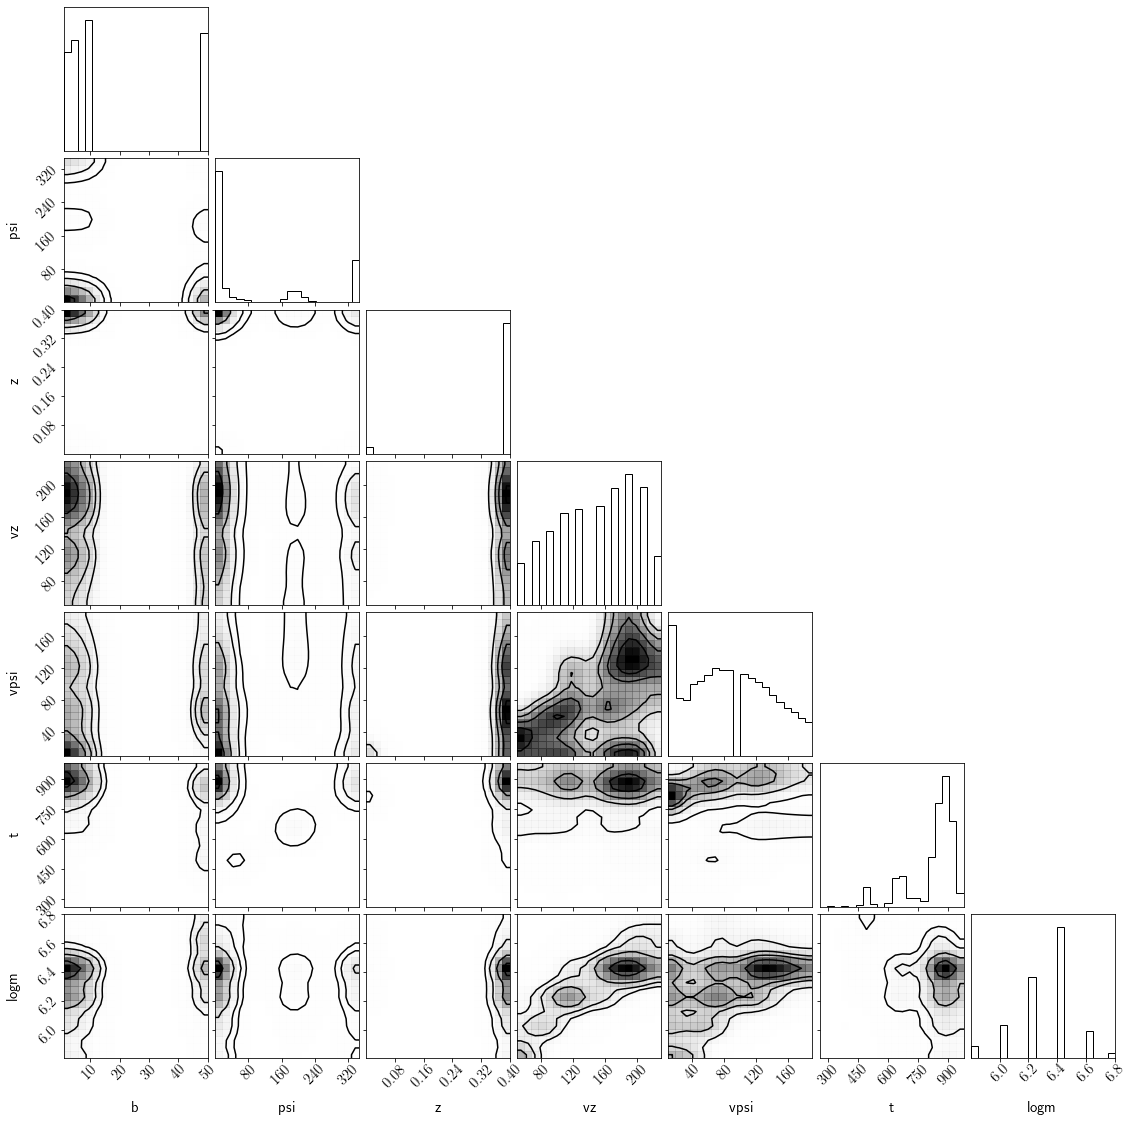

In [25]:
#non-weighted points, gap mandated
print(top_cut_data[:10])
corner.corner(for_corner_cut, labels=(r'b', r'psi', r'z', r'vz', r'vpsi', r't', r'logm'), smooth = 1.5,
             plot_datapoints = False)
plt.show()

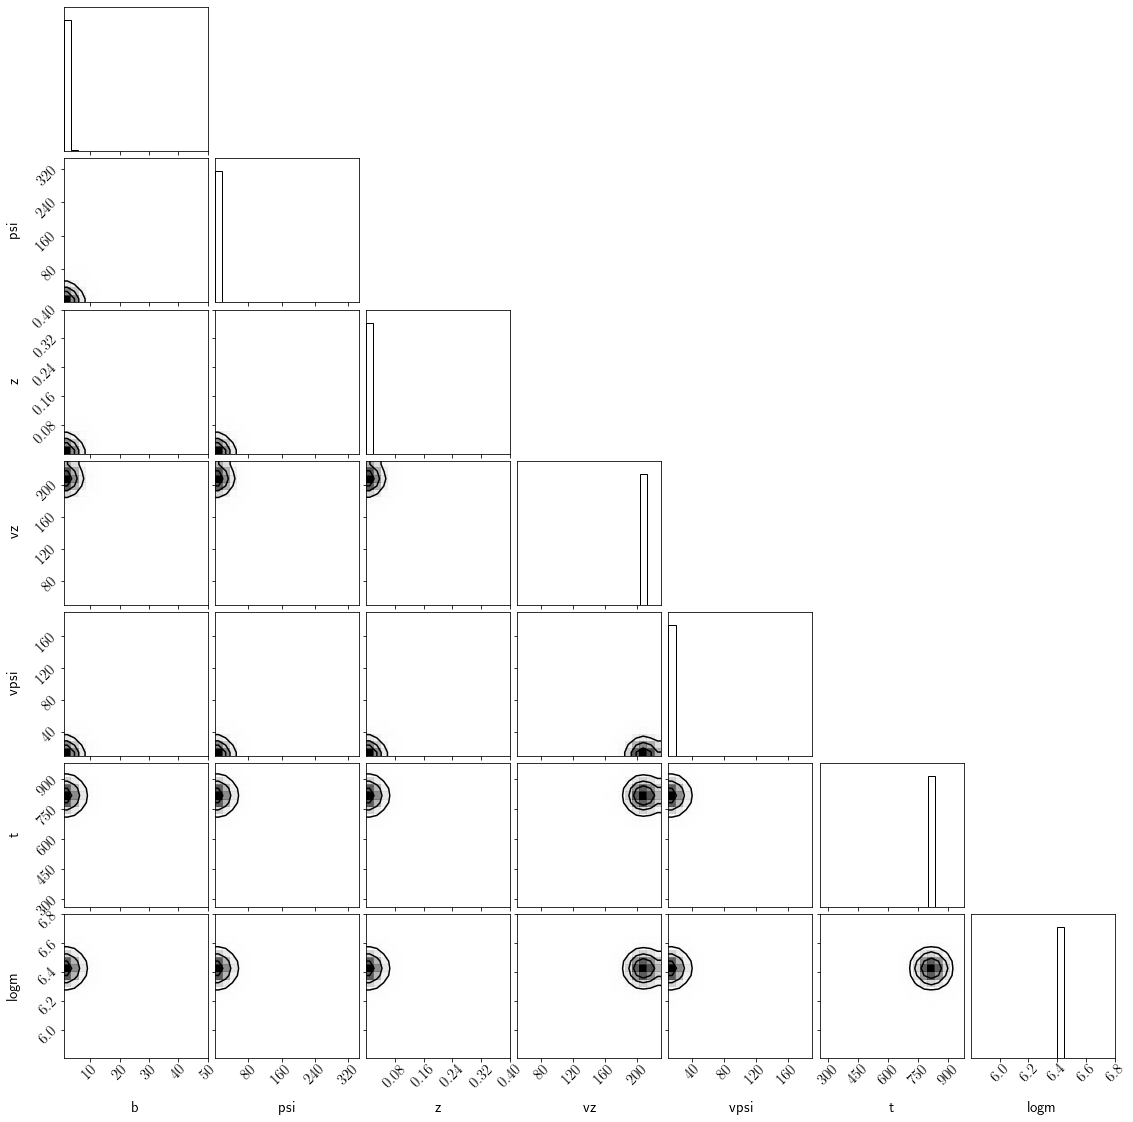

In [26]:
#weighted points, gap mandated
corner.corner(for_corner_cut, labels=(r'b', r'psi', r'z', r'vz', r'vpsi', r't', r'logm'), 
              weights = np.exp(top_cut_data['logprob_model'] - top_cut_data['logprob_model'].max()), smooth = 1.5,
             plot_datapoints = False)

plt.show()

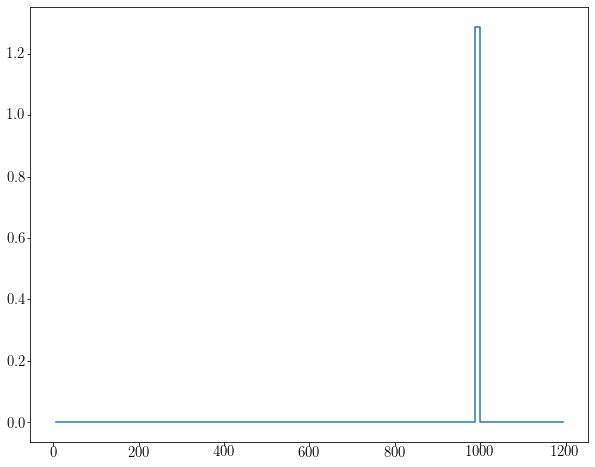

In [439]:
a, b = np.histogram(data['t'], weights = np.exp(data['logprob_model'] - data['logprob_model'].max()), 
                    bins = np.linspace(0, 1200, 100))
plt.plot( 0.5*(b[1:] + b[:-1]), a, drawstyle='steps')

In [63]:
vals = np.array(list(top_data[0])[:7])
#vals = np.array(list(top_cut_data[0])[:7])
print(vals)

[  1.    0.    0.  170.   10.  820.    6.2]


-0.026089680568739865
-1549.5750181842027
-0.026089680568739865
making directory


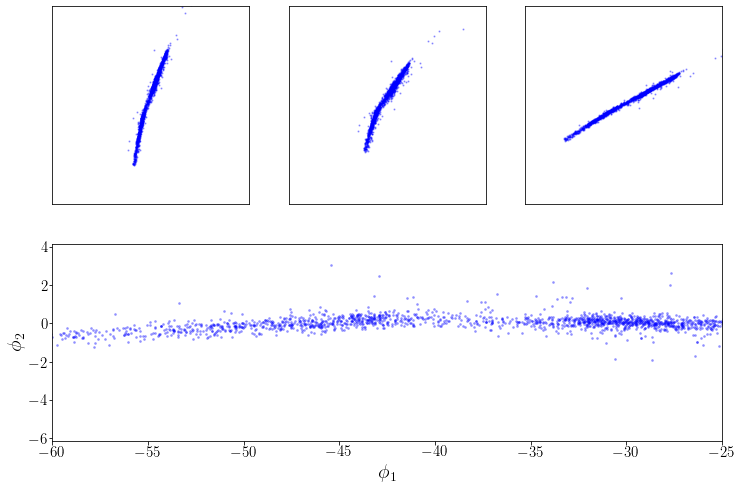

In [62]:
importlib.reload(mp)
importlib.reload(fp)
#data = Table.read('../data/full_table0.fits')
#t10 = data[:5]

fitpert = fp.FitPert()
ll, _, _, _, _ = fitpert.loglik_model_kde(vals)
print(ll)
_, orbits = fitpert.nbody()
mp.save_gifs(int(vals[5]), orbits, 13)
plot_pretty(fontsize=20, labelsize=15)
plots = mp.Plotting()
plots.final_pos(orbits, 13)
    
# 0 is the best from the full run
# 1 is the second best from the full run
# 2 is the best from t<900
# 3 is the best when mandating a gap in the right place <0.75
# 4 includes rv kde and is the best from the full run
# 5 includes rv kde and mandates a gap in the right place <0.75
# 6 includes rv kde and is the best from the full run, perturber is bound
# 7 includes rv kde and mandates a gap in the right place < 0.75, perturber is bound
# 8 includes rv kde and mandates a gap in the right place < 0.6, perturber is bound
# 9 is best from low time run. This is what I believe in my heart is correct. Fixing the proper motions from the
## orbit fit will give this answer (or a similar one) I think
# 10 is after the proper motion was fixed, best outcome
# 11 is after pm fixed and grid expanded/adjusted, best outcome
# 12 is after pm fixed and grid expanded/adjusted, best outcome with gap required
# 13 is after pm fixed and grid expanded/adjusted, second best outcome

Notice: It seems that at higher impact time, the mass of the perturber is generally higher (compare histograms for logm of the two graphs)

In [633]:
# figuring out what we should use as our Hernquist potential core radius using Erkal+16
#r_s = 1.05 kpc (M_subhalo / (10^8 M_sun))^0.5
#using logm = 6.8 as an approximation since thats the value for the best result:
r_s = 1.05 * (10**6.8 / (10**8))**0.5
print(r_s)

0.26374807530850586


#### Considering a change in parameters

Figure out the change in energy caused by the perturber, from Yoon+11
$$\Delta E = v_{stream} \times (-\frac{2GM_{sub}x}{v_{rel}b^2} \frac{v_z^2}{v_z^2 (x/b)^2 + v_{rel}^2})$$

For a direct impact: 
$$\Delta E (b=0) = 2 \frac{GM_{sub}}{x} \frac{v_{stream}}{v_{enc}}$$

Question: Given just a change in energy, can I implement the N-body simulation or does that not work?
The issue with reparameterizing in this way is that it doesn't give enough information to start the N-body simulation because to do so, I need the relative velocity as a number. Or is the idea that for each energy value at a given time, I choose a number of combinations of mass and relative velocity that give me that energy. This then runs into a problem of velocity configurations, since there are many ways to achieve the desired total relative velocity.

Testing the numbers: If in the original grid I have 6 masses, and 20 values of velocity in each of the two directions, then I have 2400 total grid points. Lets say in the new grid, I have 20 values that I want to test. I am still only testing for ~6 masses which gives me ~120 points. But for each relative velocity taken from the energy and mass, we need to figure out different configurations of vz vs vpsi. We only need to vary one, since the other one is automatically derived. If we choose 10 possible values (let's say for vpsi) then I have ~1200 points. So this should reduce computation time by 1/2

But then I will not be constraining the mass directly so is this worth it given that it's not a huge gain, given the that it remains on the order of days to run.

In [110]:
importlib.reload(fp)

fitpert = fp.FitPert()
Es = []
for i in range(5000):
    vals = np.append(np.array(list(data[i])), 0.1)
    b, vz, vpsi, m = vals[0], vals[2], vals[3], 10**vals[5]
    _, vstream = fitpert.pre_fitting(vals)
    vrel = np.sqrt(vz**2 + vpsi**2)
    #choices: pick 250 pc for x, the important thing is to have this be the same value for every calculation
    deltaE = 2*4.3E-3 * m * vstream * 250 * vz**2 / (vrel * b**2 * (vz**2 * (250/b)**2 + vrel**2))
    Es = np.append(Es, deltaE)

#### More ideas
Another thing we could do is look at the gap size and gap depth expressions from Erkal+16

For a flat rotation curve, this depends on the time since the interaction, relative velocity, and the mass of the perturber. (Very similar to $\Delta E$ dependencies from above)
This might be able to give a sense of the ratios between some of the parameters and may help reduce the parameter space

In [81]:
importlib.reload(fp)

fitpert = fp.FitPert()


ll, kde_phi2, kde_pm1, kde_pm2, kde_rv = fitpert.loglik_model_kde([ 1.,   0., 0.4, 190.,  20.,  800., 6.4])
current, orbits = fitpert.nbody()
print(ll)

-0.025392320490420867
-0.025392320490420867
-1598.1954528065926


Text(0, 0.5, '$\\phi_2$')

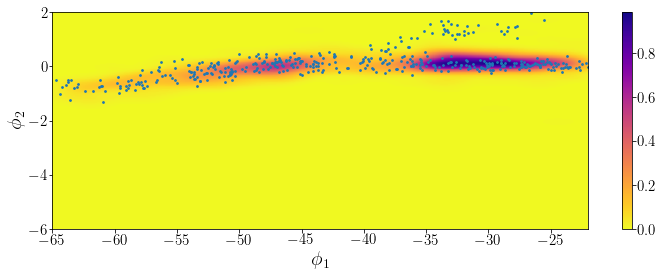

In [82]:
X, Y = np.meshgrid(np.linspace(-65, -22, 500), np.linspace(-6, 2,500))
sc = kde_phi2.score_samples(np.array([(X.flatten())/10, Y.flatten()]).T).reshape(500, 500)
plt.figure(figsize=(12,4))
plt.pcolormesh(X, Y, np.e**sc, cmap='plasma_r')
plt.colorbar()
datap = model_output[(model_output.phi1[:,0] > -65) & (model_output.phi1[:,0] < -22)]
plt.scatter(datap.phi1, datap.phi2, s=3, alpha=1)
plt.xlabel(r'$\phi_1$')
plt.ylabel(r'$\phi_2$')

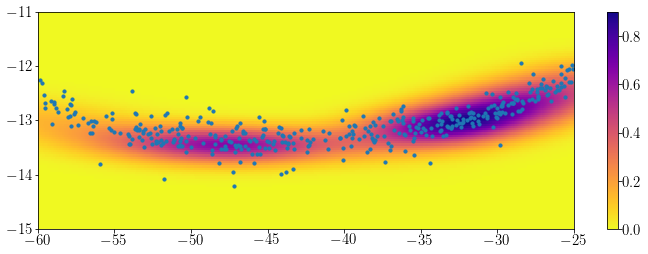

In [83]:
X, Y = np.meshgrid(np.linspace(-60, -25, 500), np.linspace(-15, -11,100))
sc = kde_pm1.score_samples(np.array([(X.flatten())/15, Y.flatten()]).T).reshape(100, 500)
plt.figure(figsize=(12,4))
plt.pcolormesh(X, Y, np.e**sc, cmap='plasma_r')
plt.colorbar()
datap = model_output[(model_output.phi1[:,0] > -60) & (model_output.phi1[:,0] < -25)]
plt.scatter(datap.phi1, datap.pm1, s=10, alpha=1)

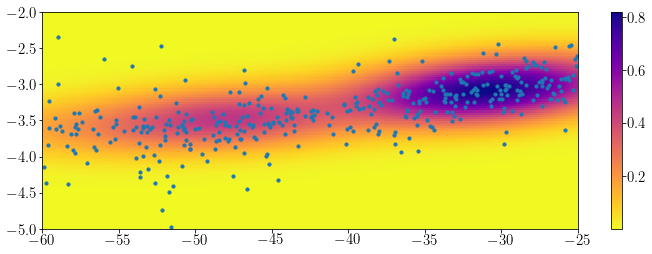

In [84]:
X, Y = np.meshgrid(np.linspace(-60, -25, 500), np.linspace(-5, -2,100))
sc = kde_pm2.score_samples(np.array([(X.flatten())/15, Y.flatten()]).T).reshape(100, 500)
plt.figure(figsize=(12,4))
plt.pcolormesh(X, Y, np.e**sc, cmap='plasma_r')
plt.colorbar()
datap = model_output[(model_output.phi1[:,0] > -60) & (model_output.phi1[:,0] < -25)]
plt.scatter(datap.phi1, datap.pm2, s=10, alpha=1)

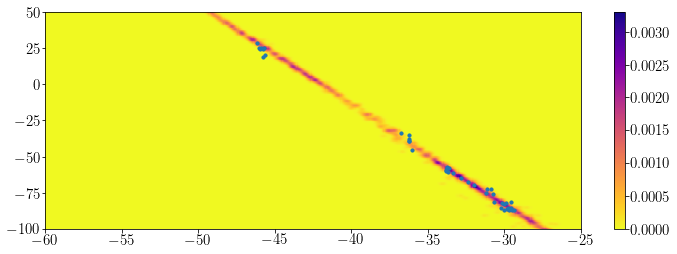

In [68]:
X, Y = np.meshgrid(np.linspace(-60, -25, 500), np.linspace(-100, 50,300))
sc = kde_rv.score_samples(np.array([(X.flatten()*5), Y.flatten()]).T).reshape(300, 500)
plt.figure(figsize=(12,4))
plt.pcolormesh(X, Y, np.e**sc, cmap='plasma_r')
plt.colorbar()
plt.scatter(gd1_rv_bonaca.phi1, gd1_rv_bonaca.Vrad, s=10, alpha=1)

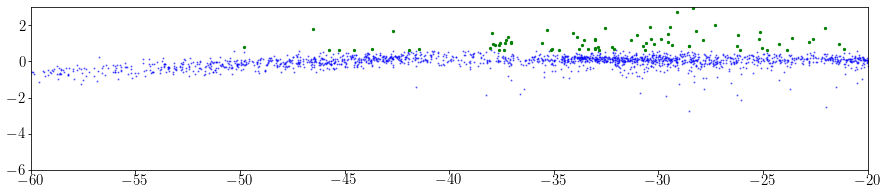

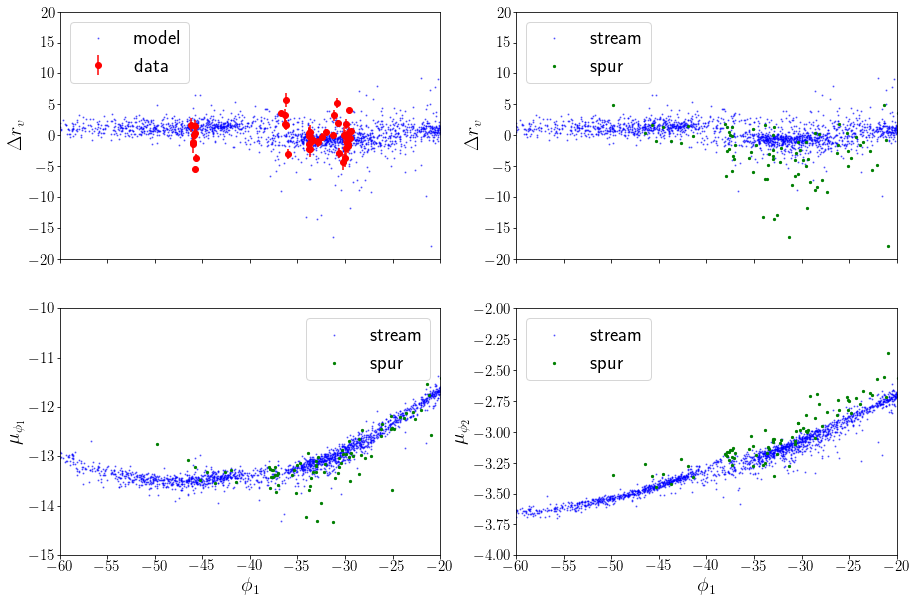

In [69]:
#no gap mandate

rv_bonaca_data = fits.open('../data/rv_catalog.fits')[1].data
gd1_rv_bonaca = rv_bonaca_data[rv_bonaca_data.pmmem & rv_bonaca_data.cmdmem & rv_bonaca_data.vrmem 
                               & rv_bonaca_data.fehmem]
var_rv = gd1_rv_bonaca.std_Vrad**2
m, b = np.polyfit(current.phi1.value, current.radial_velocity.value, deg=1)
diff_rv = gd1_rv_bonaca.Vrad - (m*gd1_rv_bonaca.phi1 + b)
loglike_rv = np.sum(-0.5 * (np.log(var_rv) + ((diff_rv**2)/var_rv) + np.log(2*np.pi)))

spur_section = current[current.phi2.value > 0.6]

plt.figure(figsize=(15, 3))
plt.scatter(current.phi1.value, current.phi2.value, c = 'b', s = 1, alpha = 0.5, label='stream')
plt.scatter(spur_section.phi1.value, spur_section.phi2.value, c = 'g', s = 5, label='spur')
plt.xlim(-60, -20)
plt.ylim(-6, 3)


fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharex = True, figsize=(15, 10))
ax1.errorbar(gd1_rv_bonaca.phi1, gd1_rv_bonaca.Vrad - spline_rv(gd1_rv_bonaca.phi1), yerr=gd1_rv_bonaca.std_Vrad,
              c = 'r', fmt='o', label='data')
ax1.scatter(current.phi1.value, current.radial_velocity.value - spline_rv(current.phi1.value),
            c='b',s=1, alpha = 0.5,label='model')
ax1.set_ylim(-20, 20)
ax1.set_xlim(-60, -20)
ax1.set_ylabel(r'$\Delta{r_v}$')
ax1.legend()

ax2.scatter(current.phi1.value, current.radial_velocity.value - spline_rv(current.phi1.value), 
            c = 'b', s = 1, alpha=0.5, label='stream')
ax2.scatter(spur_section.phi1.value, spur_section.radial_velocity.value - spline_rv(spur_section.phi1.value), 
            c = 'g', s = 5, label = 'spur')
ax2.set_xlim(-60, -20)
ax2.set_ylim(-20, 20)
ax2.set_ylabel(r'$\Delta{r_v}$')
ax2.legend()

ax3.scatter(current.phi1.value, current.pm_phi1_cosphi2.value, c = 'b', s = 1, alpha = 0.5, label='stream')
ax3.scatter(spur_section.phi1.value, spur_section.pm_phi1_cosphi2.value, c = 'g', s = 5, label='spur')
#ax3.scatter(model_output.phi1, model_output.pm1, c='r', s = 0.5)
ax3.set_xlim(-60, -20)
ax3.set_ylim(-15, -10)
ax3.set_xlabel(r'$\phi_1$')
ax3.set_ylabel(r'$\mu_{\phi_1}$')
ax3.legend()

ax4.scatter(current.phi1.value, current.pm_phi2.value, c = 'b', s = 1, alpha = 0.5, label='stream')
ax4.scatter(spur_section.phi1.value, spur_section.pm_phi2.value, c = 'g', s = 5, label='spur')
#ax4.plot(spur_section.phi1.value, 0.035*spur_section.phi1.value - 1.9, c = 'r')
#ax4.scatter(model_output.phi1, model_output.pm2, c='r', s = 0.5)
ax4.set_xlim(-60, -20)
ax4.set_ylim(-4, -2)
ax4.set_xlabel(r'$\phi_1$')
ax4.set_ylabel(r'$\mu_{\phi_2}$')
ax4.legend()
plt.show()

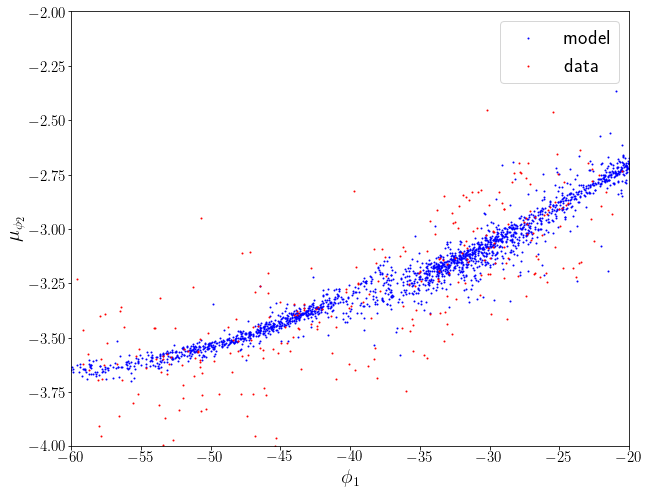

In [70]:
plt.scatter(current.phi1.value, current.pm_phi2.value, c = 'b', s = 1, alpha = 1, label='model')
#plt.scatter(spur_section.phi1.value, spur_section.pm_phi2.value, c = 'g', s = 5, label='spur')
plt.scatter(model_output.phi1, model_output.pm2, c='r', s = 1, label='data')
plt.xlim(-60, -20)
plt.ylim(-4, -2)
plt.xlabel(r'$\phi_1$')
plt.ylabel(r'$\mu_{\phi_2}$')
plt.legend()
plt.show()

(-6.0, 3.0)

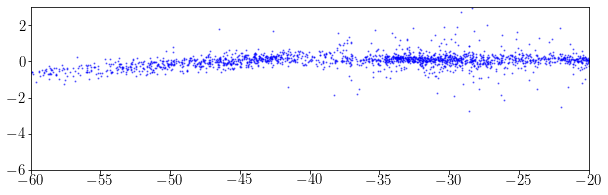

In [71]:
plt.figure(figsize=(10,3))
plt.scatter(current.phi1, current.phi2, s = 1, alpha = 0.5, c='b')
#plt.scatter(data_gd1.phi1, data_gd1.phi2, c='k', s = 1)
plt.xlim(-60, -20)
plt.ylim(-6,3)

In [624]:
np.mean(gd1_rv_bonaca.std_Vrad)

0.8189717690100835

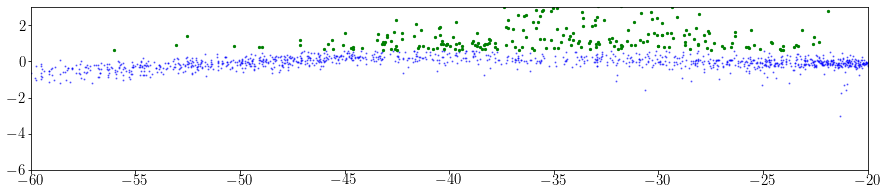

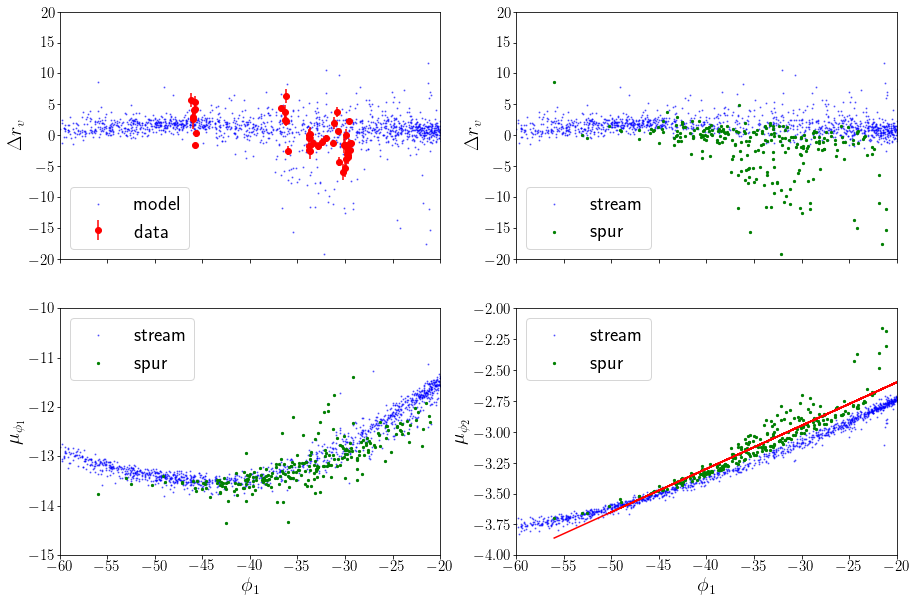

In [709]:
#including a gap mandate

rv_bonaca_data = fits.open('../data/rv_catalog.fits')[1].data
gd1_rv_bonaca = rv_bonaca_data[rv_bonaca_data.pmmem & rv_bonaca_data.cmdmem & rv_bonaca_data.vrmem 
                               & rv_bonaca_data.fehmem]
var_rv = gd1_rv_bonaca.std_Vrad**2
m, b = np.polyfit(current.phi1.value, current.radial_velocity.value, deg=1)
diff_rv = gd1_rv_bonaca.Vrad - (m*gd1_rv_bonaca.phi1 + b)
loglike_rv = np.sum(-0.5 * (np.log(var_rv) + ((diff_rv**2)/var_rv) + np.log(2*np.pi)))

spur_section = current[current.phi2.value > 0.6]

plt.figure(figsize=(15, 3))
plt.scatter(current.phi1.value, current.phi2.value, c = 'b', s = 1, alpha = 0.5, label='stream')
plt.scatter(spur_section.phi1.value, spur_section.phi2.value, c = 'g', s = 5, label='spur')
plt.xlim(-60, -20)
plt.ylim(-6, 3)


fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharex = True, figsize=(15, 10))
ax1.errorbar(gd1_rv_bonaca.phi1, gd1_rv_bonaca.Vrad - spline_rv(gd1_rv_bonaca.phi1), yerr=gd1_rv_bonaca.std_Vrad,
              c = 'r', fmt='o', label='data')
ax1.scatter(current.phi1.value, current.radial_velocity.value - spline_rv(current.phi1.value),
            c='b',s=1, alpha = 0.5,label='model')
ax1.set_ylim(-20, 20)
ax1.set_xlim(-60, -20)
ax1.set_ylabel(r'$\Delta{r_v}$')
ax1.legend()

ax2.scatter(current.phi1.value, current.radial_velocity.value - spline_rv(current.phi1.value), 
            c = 'b', s = 1, alpha=0.5, label='stream')
ax2.scatter(spur_section.phi1.value, spur_section.radial_velocity.value - spline_rv(spur_section.phi1.value), 
            c = 'g', s = 5, label = 'spur')
ax2.set_xlim(-60, -20)
ax2.set_ylim(-20, 20)
ax2.set_ylabel(r'$\Delta{r_v}$')
ax2.legend()

ax3.scatter(current.phi1.value, current.pm_phi1_cosphi2.value, c = 'b', s = 1, alpha = 0.5, label='stream')
ax3.scatter(spur_section.phi1.value, spur_section.pm_phi1_cosphi2.value, c = 'g', s = 5, label='spur')
#ax3.scatter(model_output.phi1, model_output.pm1, c='r', s = 0.5)
ax3.set_xlim(-60, -20)
ax3.set_ylim(-15, -10)
ax3.set_xlabel(r'$\phi_1$')
ax3.set_ylabel(r'$\mu_{\phi_1}$')
ax3.legend()

ax4.scatter(current.phi1.value, current.pm_phi2.value, c = 'b', s = 1, alpha = 0.5, label='stream')
ax4.scatter(spur_section.phi1.value, spur_section.pm_phi2.value, c = 'g', s = 5, label='spur')
ax4.plot(spur_section.phi1.value, 0.035*spur_section.phi1.value - 1.9, c = 'r')
#ax4.scatter(model_output.phi1, model_output.pm2, c='r', s = 0.5)
ax4.set_xlim(-60, -20)
ax4.set_ylim(-4, -2)
ax4.set_xlabel(r'$\phi_1$')
ax4.set_ylabel(r'$\mu_{\phi_2}$')
ax4.legend()
plt.show()

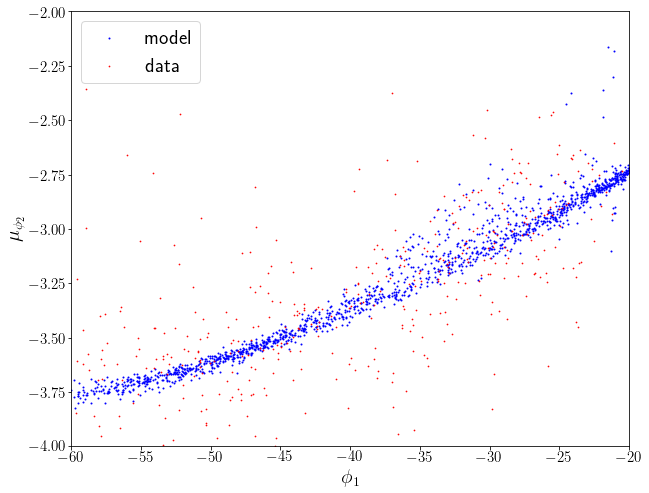

In [715]:
plt.scatter(current.phi1.value, current.pm_phi2.value, c = 'b', s = 1, alpha = 1, label='model')
#plt.scatter(spur_section.phi1.value, spur_section.pm_phi2.value, c = 'g', s = 5, label='spur')
plt.scatter(model_output.phi1, model_output.pm2, c='r', s = 0.5, label='data')
plt.xlim(-60, -20)
plt.ylim(-4, -2)
plt.xlabel(r'$\phi_1$')
plt.ylabel(r'$\mu_{\phi_2}$')
plt.legend()
plt.show()

(-6.0, 3.0)

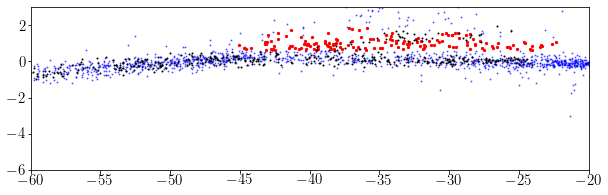

In [712]:
test = spur_section[spur_section.pm_phi2.value < 0.035*spur_section.phi1.value - 1.9]
plt.figure(figsize=(10,3))
plt.scatter(current.phi1, current.phi2, s = 1, alpha = 0.5, c='b')
plt.scatter(test.phi1, test.phi2, c = 'r', s = 5)
plt.scatter(data_gd1.phi1, data_gd1.phi2, c='k', s = 1)
plt.xlim(-60, -20)
plt.ylim(-6,3)

### Post model checks

We want to require our final model to have certain features. Loglikelihoods cannot tell us everything and our eyes are trustworthy in some ways so we can impose some additional requirements and then take the best of the remaining loglikelihoods.

Potential requirements:
1. Few stars in between spur and stream
2. Few stars below the stream (in stream coordinates)
3. Radial velocity
4. There exists a gap in the area we know there is one. Quantify the width and depth of the gap and require that the model produces some similar feature. This is probably the most difficult but most important one.

I could implement these as booleans or as handicaps. Thinking of doing a Boolean for the third one and handicap for the first two if I decide to use them.

Possible implementations:
1. Add to the loglikelihood for each start that is in this region

Note: If I choose to implement this, I need to be careful because we don't have 100% guaranteee that there are not GD-1 stars in this region, and if there are, they would not show up in the post-pm model data because of the way I fit the spur

2. For every star below a certain threshold in phi2, add a certain amount to the loglikelihood
3. See below

In [72]:
#checking that there is a gap in the stream
after = GaiaData('../data/member_prob_all.fits')
model_output = after[after.post_member_prob > 0.1]
data_gd1 = model_output[(model_output.phi1[:,0] > -60) & (model_output.phi1[:,0] < -24)]
no_spur = data_gd1[(data_gd1.phi2[:,0] < 0.6)]

#creating the same histogram for the model
model_gd1 = orbits[-1, 1:].to_coord_frame(gc.GD1)
model_gd1 = model_gd1[(model_gd1.phi1.value > -60) & (model_gd1.phi1.value < -24)]
no_spur_model = model_gd1[(model_gd1.phi2.value < 0.6)]

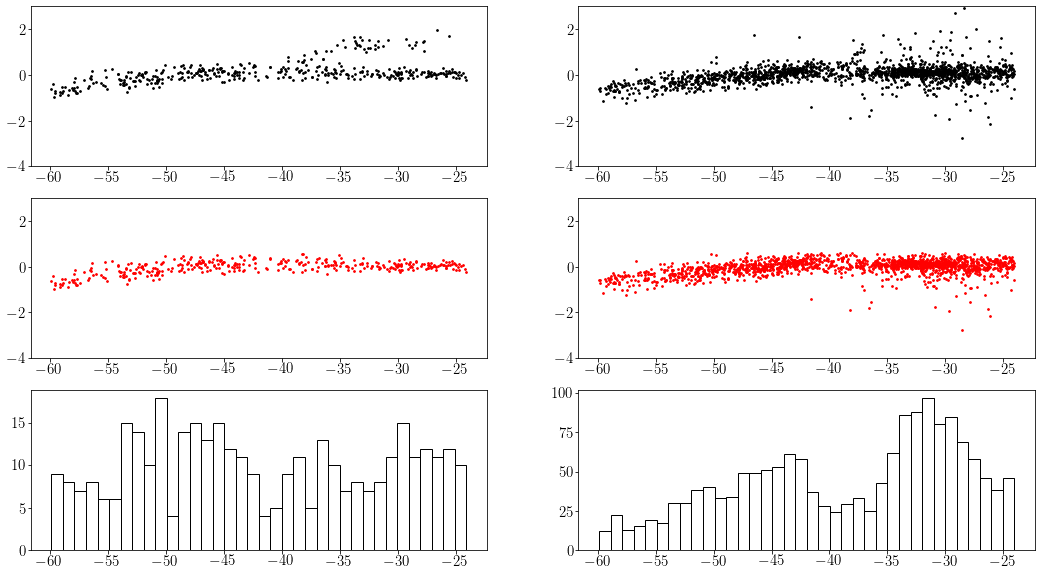

In [73]:
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=(18,10))
ax1.scatter(data_gd1.phi1, data_gd1.phi2, c='k', s = 3)
ax1.set_ylim(-4, 3)
ax3.scatter(no_spur.phi1, no_spur.phi2, c = 'r', s = 3)
ax3.set_ylim(-4, 3)
ax5.hist(no_spur.phi1, bins = 36, fill = False)

ax2.scatter(model_gd1.phi1, model_gd1.phi2, c = 'k', s = 3)
ax2.set_ylim(-4, 3)
ax4.scatter(no_spur_model.phi1, no_spur_model.phi2, c = 'r', s = 3)
ax4.set_ylim(-4, 3)
ax6.hist(no_spur_model.phi1.value, bins = 36, fill = False)
plt.show()

In [644]:
#take the average count in the range -45 to -55, which seems to be heavily populated and consistent
high_dens_data = no_spur[(no_spur.phi1[:,0] < -45) & (no_spur.phi1[:,0] > -54)]
print(len(high_dens)/9)

low_dens_data = no_spur[(no_spur.phi1[:,0] < -39) & (no_spur.phi1[:,0] > -43)]
print(len(low_dens)/4)

#take the average count in the range -45 to -55, which seems to be heavily populated and consistent
high_dens_model = no_spur_model[(no_spur_model.phi1.value < -45) & (no_spur_model.phi1.value > -54)]
print(len(high_dens_model)/9)

low_dens_model = no_spur_model[(no_spur_model.phi1.value < -39) & (no_spur_model.phi1.value > -43)]
print(len(low_dens_model)/4)

# so what I could do is mandate that the low density region less than 75% of the density of the high density region
# This is probably something to be implemented as a Boolean at the grid level for the next one.
#  There is added computation time after otherwise since orbits need to be calculated

# Should I narrow the high density region so that it doesn't include the narrow gap at -50?

13.333333333333334
6.75
34.55555555555556
34.5


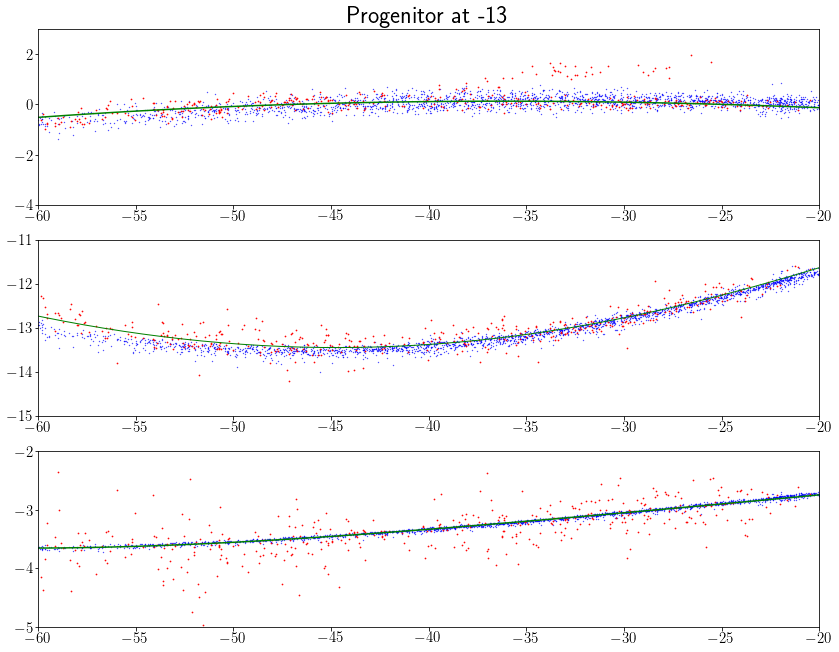

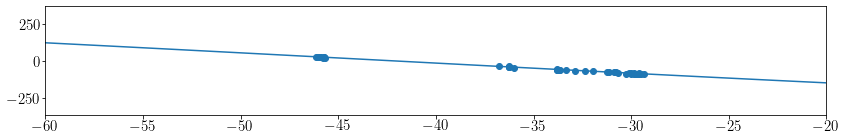

In [806]:
df = ms.FardalStreamDF(random_state=np.random.RandomState(42))

gd1_init = gc.GD1Koposov10(phi1 = -13*u.degree, phi2=0*u.degree, distance=8.836*u.kpc,
                      pm_phi1_cosphi2=-10.575*u.mas/u.yr,
                      pm_phi2=-2.439*u.mas/u.yr,
                     radial_velocity = -189.6*u.km/u.s)
rep = gd1_init.transform_to(coord.Galactocentric).data
gd1_w0 = gd.PhaseSpacePosition(rep)
gd1_mass = 5e3 * u.Msun
gd1_pot = gp.PlummerPotential(m=gd1_mass, b=5*u.pc, units=galactic)
mw = gp.MilkyWayPotential(halo={'m': 5.43e11*u.Msun, 'r_s': 15.78*u.kpc})
gen_gd1 = ms.MockStreamGenerator(df, mw, progenitor_potential=gd1_pot)
gd1_stream, gd1_nbody = gen_gd1.run(gd1_w0, gd1_mass,
                                dt=-1 * u.Myr, n_steps=3000)
gd1_stream_c1 = gd1_stream.to_coord_frame(gc.GD1)
gd1 = gd1_stream_c1[gd1_stream_c1.phi1.argsort()]

spline_pm10 = UnivariateSpline(gd1.phi1, gd1.pm_phi1_cosphi2, k=5)
spline_pm20 = UnivariateSpline(gd1.phi1, gd1.pm_phi2, k=5)
spline_rv = UnivariateSpline(gd1.phi1, gd1.radial_velocity)
spline_dist = UnivariateSpline(gd1.phi1, gd1.distance)

fig, (ax1, ax2, ax3) = plt.subplots(3,1, figsize=(14,11))
ax1.set_title('Progenitor at {}'.format(-13))
ax1.scatter(gd1_stream_c1.phi1.value, gd1_stream_c1.phi2.value, s=0.1, c='b')
ax1.scatter(model_output.phi1, model_output.phi2, c='r', s = 0.5)
ax1.plot(phi1s, spline_phi2(phi1s), c='g')
ax1.set_xlim(-60,-20)
ax1.set_ylim(-4, 3)

ax2.scatter(gd1_stream_c1.phi1, gd1_stream_c1.pm_phi1_cosphi2, s=0.1, c='b')
ax2.scatter(model_output.phi1, model_output.pm1, c='r', s = 0.5)
#plt.plot(gd1.phi1, spline_pm10(gd1.phi1), c='g', lw=3)
ax2.plot(phi1s, spline_pm1(phi1s), c='g', lw=1)
ax2.set_xlim(-60,-20)
ax2.set_ylim(-15,-11)

ax3.scatter(gd1_stream_c1.phi1, gd1_stream_c1.pm_phi2, s=0.1, c='b')
ax3.scatter(model_output.phi1, model_output.pm2, c='r', s = 0.5)
#plt.plot(gd1.phi1, spline_pm20(gd1.phi1), c='g', lw=2)
ax3.plot(phi1s, spline_pm2(phi1s), c='g')
ax3.set_xlim(-60,-20)
ax3.set_ylim(-5,-2)


plt.figure(figsize = (14,2))
rv_bonaca_data = fits.open('../data/rv_catalog.fits')[1].data
gd1_rv_bonaca = rv_bonaca_data[rv_bonaca_data.pmmem & rv_bonaca_data.cmdmem & rv_bonaca_data.vrmem 
                               & rv_bonaca_data.fehmem]

plt.scatter(gd1_rv_bonaca.phi1, gd1_rv_bonaca.Vrad)
plt.plot(phi1s, spline_rv(phi1s))
plt.xlim(-60, -20)
plt.show()

In [77]:
orbit = mw.integrate_orbit(w0_now, dt=-1*u.Myr, n_steps=int(300))
old_gd1 = orbit[-1]

# Converting from xyz to relative-to-stream coordinates and back again
#take the velocities of the stream particles where the pertuber will cross the stream
center = old_gd1[(np.abs(np.mean(old_gd1.pos.x.value) - old_gd1.pos.x.value) < 0.5) & 
             (np.abs(np.mean(old_gd1.pos.y.value) - old_gd1.pos.y.value) < 0.5) & 
             (np.abs(np.mean(old_gd1.pos.z.value) - old_gd1.pos.z.value) < 0.5)]

vxstream = np.mean(center.vel.d_x).to(u.km/u.s).value
vystream = np.mean(center.vel.d_y).to(u.km/u.s).value
vzstream = np.mean(center.vel.d_z).to(u.km/u.s).value

In [78]:
site_at_impact_w0 = gd.PhaseSpacePosition(pos=np.mean(old_gd1.pos),vel=[vxstream, vystream, vzstream]*u.km/u.s)
print(site_at_impact_w0)

pos=(17.02033982, -0.20371474, -9.95769503) kpc
vel=(105.80687469, 165.42390658, 41.12840051) km / s


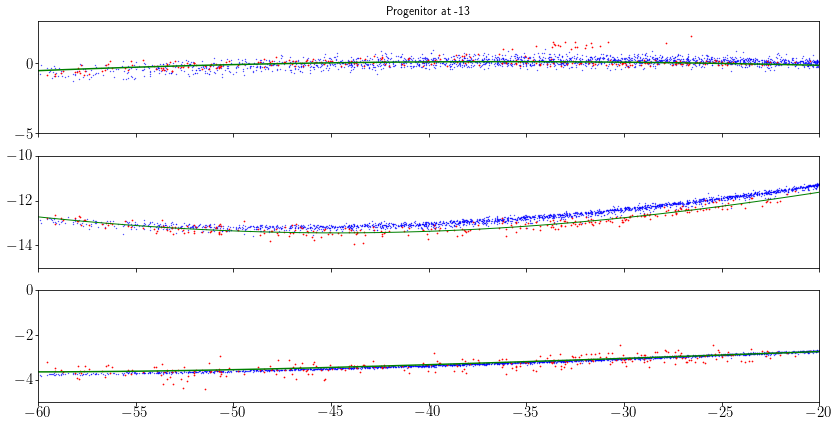

In [120]:
fig, (ax1, ax2, ax3) = plt.subplots(3,1, figsize=(14,7), sharex=True)
ax1.set_title('Progenitor at {}'.format(-13))
ax1.scatter(gd1_stream_c1.phi1.value, gd1_stream_c1.phi2.value, s=0.1, c='b')
ax1.scatter(model_output.phi1, model_output.phi2, c='r', s = 0.5)
ax1.plot(phi1s, spline_phi2(phi1s), c='g')
ax1.set_xlim(-60,-20)
ax1.set_ylim(-5, 3)

ax2.scatter(gd1_stream_c1.phi1, gd1_stream_c1.pm_phi1_cosphi2, s=0.1, c='b')
ax2.scatter(model_output.phi1, model_output.pm1, c='r', s = 0.5)
#plt.plot(gd1.phi1, spline_pm10(gd1.phi1), c='g', lw=3)
ax2.plot(phi1s, spline_pm1(phi1s), c='g', lw=1)

ax2.set_ylim(-15,-10)

ax3.scatter(gd1_stream_c1.phi1, gd1_stream_c1.pm_phi2, s=0.1, c='b')
ax3.scatter(model_output.phi1, model_output.pm2, c='r', s = 0.5)
#plt.plot(gd1.phi1, spline_pm20(gd1.phi1), c='g', lw=2)
ax3.plot(phi1s, spline_pm2(phi1s), c='g')
ax3.set_ylim(-5,0)
plt.show()

## Some more plots

(-100.0, 100.0)

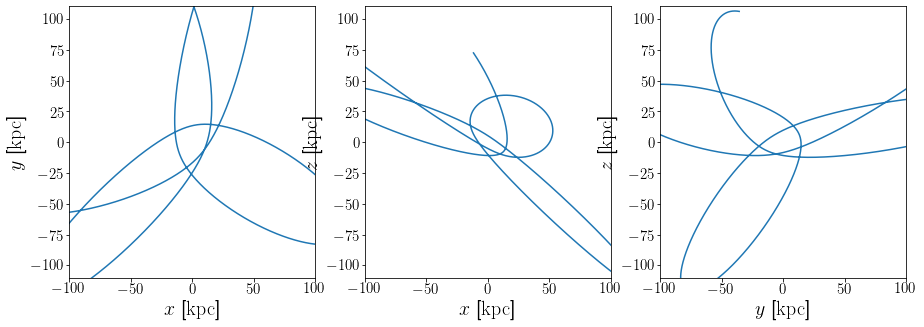

In [849]:
#the perturber's
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
orbit_pert = mw.integrate_orbit(orbits[-1,0], dt=-1*u.Myr, n_steps=12000)
orbit_pert.plot(['x', 'y'], axes = ax1)  
orbit_pert.plot(['x', 'z'], axes = ax2) 
orbit_pert.plot(['y', 'z'], axes = ax3) 

#stream_orbit = mw.integrate_orbit(gd1_w0, dt=-1*u.Myr, n_steps = 1000)
#stream_orbit.plot(['x', 'y'], axes = ax1, c = 'r')  
#stream_orbit.plot(['x', 'z'], axes = ax2, c = 'r') 
#stream_orbit.plot(['y', 'z'], axes = ax3, c = 'r') 
ax1.set_xlim(-100,100)
ax1.set_ylim(-100,100)
ax2.set_xlim(-100,100)
ax2.set_ylim(-100,100)
ax3.set_xlim(-100,100)
ax3.set_ylim(-100,100)

In [850]:
print(orbit_pert.apocenter().value)
print(orbit_pert.pericenter())

190.65036095097383
14.50446396016994 kpc


In [127]:


c = coord.SkyCoord(x=orbits[-1,0].pos.x, y=orbits[-1,0].pos.y, z=orbits[-1,0].pos.z, 
                   representation_type='cartesian')

c.transform_to('fk5')

<SkyCoord (FK5: equinox=J2000.000): (ra, dec, distance) in (deg, deg, kpc)
    (245.55377641, -12.86836475, 87.08995732)>

<IPython.core.display.Javascript object>


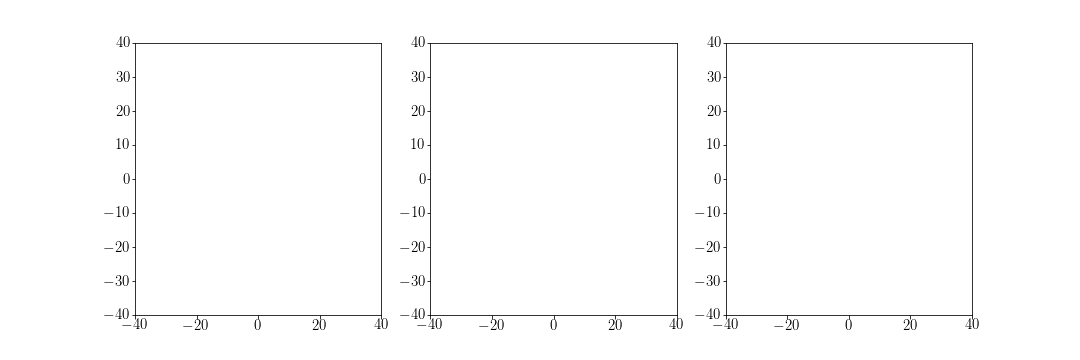

In [21]:
%matplotlib notebook
from matplotlib.animation import FuncAnimation
orbit_pert = mw.integrate_orbit(orbits[-1,0], dt=-1*u.Myr, n_steps=1000)
stream_orbit = mw.integrate_orbit(gd1_w0, dt=-1*u.Myr, n_steps = 1000)


def orbit_mov(frame):
    print(stream_orbit.x.value[frame])
    stream1.set_data(stream_orbit.x.value[frame], stream_orbit.y.value[frame])
    stream2.set_data(stream_orbit.x[frame], stream_orbit.z[frame])
    stream3.set_data(stream_orbit.y[frame], stream_orbit.z[frame])
    
    #pert1.set_data(orbit_pert.x[frame], orbit_pert.y[frame])
    #pert2.set_data(orbit_pert.x[frame], orbit_pert.z[frame])
    #pert3.set_data(orbit_pert.y[frame], orbit_pert.z[frame])
    
    
    return [stream1, stream2, stream3]
    
    
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,5))
for ax in [ax1, ax2, ax3]:
    ax.set_xlim(-40,40)
    ax.set_ylim(-40,40)

    
stream1, = ax1.plot([], [], c = 'r')
#pert1, = ax1.plot([], [])
stream2, = ax2.plot([], [], c = 'r')
#pert2, = ax2.plot([], [])
stream3, = ax3.plot([], [], c = 'r')
#pert3, = ax3.plot([], [])


animation = FuncAnimation(fig, orbit_mov, frames=1000, blit = True, interval=10)
plt.show()

<IPython.core.display.Javascript object>


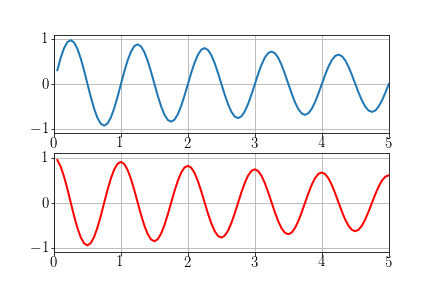

In [15]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

def data_gen():
    t = data_gen.t
    cnt = 0
    while cnt < 100:
        cnt+=1
        t += 0.05
        y1 = np.sin(2*np.pi*t) * np.exp(-t/10.)
        y2 = np.cos(2*np.pi*t) * np.exp(-t/10.)
        # adapted the data generator to yield both sin and cos
        yield t, y1, y2

data_gen.t = 0

# create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(2,1)

# intialize two line objects (one in each axes)
line1, = ax1.plot([], [], lw=2)
line2, = ax2.plot([], [], lw=2, color='r')
line = [line1, line2]

# the same axes initalizations as before (just now we do it for both of them)
for ax in [ax1, ax2]:
    ax.set_ylim(-1.1, 1.1)
    ax.set_xlim(0, 5)
    ax.grid()

# initialize the data arrays 
xdata, y1data, y2data = [], [], []
def run(data):
    # update the data
    t, y1, y2 = data
    xdata.append(t)
    y1data.append(y1)
    y2data.append(y2)

    # axis limits checking. Same as before, just for both axes
    for ax in [ax1, ax2]:
        xmin, xmax = ax.get_xlim()
        if t >= xmax:
            ax.set_xlim(xmin, 2*xmax)
            ax.figure.canvas.draw()

    # update the data of both line objects
    line[0].set_data(xdata, y1data)
    line[1].set_data(xdata, y2data)

    return line

ani = animation.FuncAnimation(fig, run, data_gen, blit=True, interval=10,
    repeat=False)
plt.show()

## Making a figure describing the grid parameters

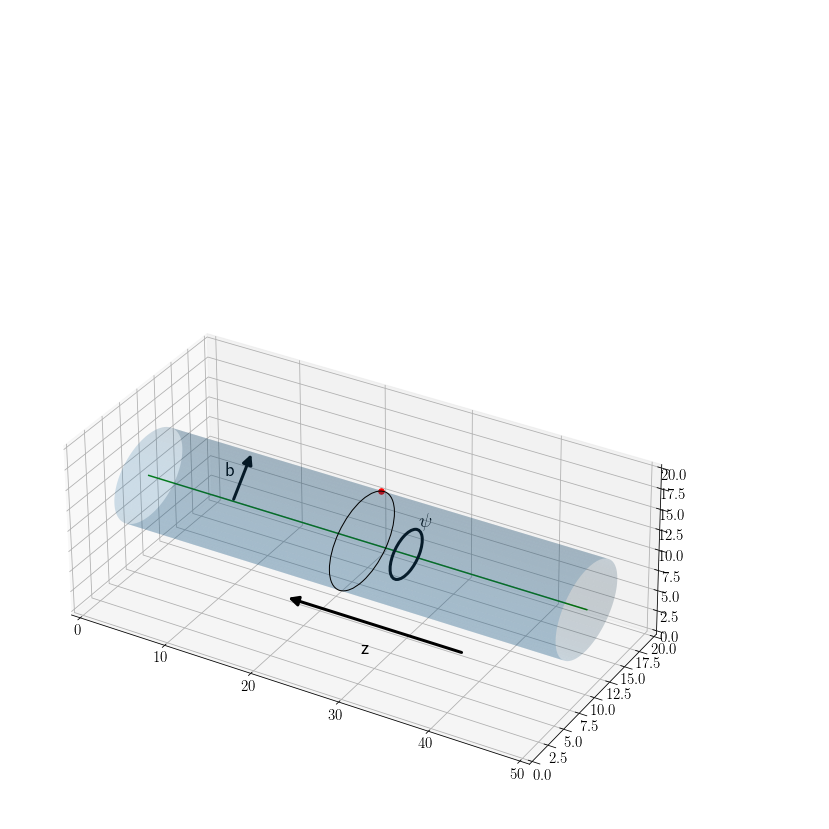

In [207]:
# choose a line along which to

#axis and radius
p0 = np.array([0, 10, 10])
p1 = np.array([50, 10, 10])
R = 5
#vector in direction of axis
v = p1 - p0
#find magnitude of vector
mag = np.linalg.norm(v)
#unit vector in direction of axis
v = v / mag
#make some vector not in the same direction as v
not_v = np.array([1, 0, 0])
if (v == not_v).all():
    not_v = np.array([0, 1, 0])
#make vector perpendicular to v
n1 = np.cross(v, not_v)
#normalize n1
n1 /= np.linalg.norm(n1)
#make unit vector perpendicular to v and n1
n2 = np.cross(v, n1)
#surface ranges over t from 0 to length of axis and 0 to 2*pi
t = np.linspace(0, mag, 100)
theta = np.linspace(0, 2 * np.pi, 100)
#use meshgrid to make 2d arrays
t, theta = np.meshgrid(t, theta)
#generate coordinates for surface
X, Y, Z = [p0[i] + v[i] * t + R * np.sin(theta) * n1[i] + R * np.cos(theta) * n2[i] for i in [0, 1, 2]]


import matplotlib.pyplot as plt
from matplotlib.patches import Circle, PathPatch
from mpl_toolkits.mplot3d import Axes3D 
import mpl_toolkits.mplot3d.art3d as art3d


fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(projection='3d')
ax.get_proj = lambda: np.dot(Axes3D.get_proj(ax), np.diag([1, 0.5, 0.5, 1]))

circle = Circle((10, 10), 5, fill=False)
ax.add_patch(circle)
art3d.pathpatch_2d_to_3d(circle, z=25, zdir='x')




ax.plot_surface(X, Y, Z, alpha=0.2, )
#plot axis
ax.plot(*zip(p0, p1), color = 'green')
ax.set_xlim(0, 50)
ax.set_ylim(0, 20)
ax.set_zlim(0, 20)

#perturber
ax.scatter(25, 13, 14, c='red', s=30)

#arrows
a = Arrow3D([40, 20], [5, 5], 
                [5, 5], mutation_scale=20, 
                lw=3, arrowstyle="-|>", color="k")
ax.add_artist(a)
ax.text(30, 3, 3, 'z')

b = Arrow3D([10, 10], [10, 13], 
                [10, 14], mutation_scale=20, 
                lw=3, arrowstyle="-|>", color="k")
ax.add_artist(b)
ax.text(8.5, 11, 12, 'b')

arc = mpl.patches.Arc((10,10), 5, 5, 100, theta1 = 0, theta2=90, color='k', lw=3)
ax.add_patch(arc)
art3d.pathpatch_2d_to_3d(arc, z=30, zdir='x')
ax.text(30, 12, 12, r'$\psi$')

plt.show()

In [124]:
import numpy as np
from numpy import *
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import proj3d

class Arrow3D(FancyArrowPatch):
    def __init__(self, xs, ys, zs, *args, **kwargs):
        FancyArrowPatch.__init__(self, (0,0), (0,0), *args, **kwargs)
        self._verts3d = xs, ys, zs

    def draw(self, renderer):
        xs3d, ys3d, zs3d = self._verts3d
        xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
        self.set_positions((xs[0],ys[0]),(xs[1],ys[1]))
        FancyArrowPatch.draw(self, renderer)


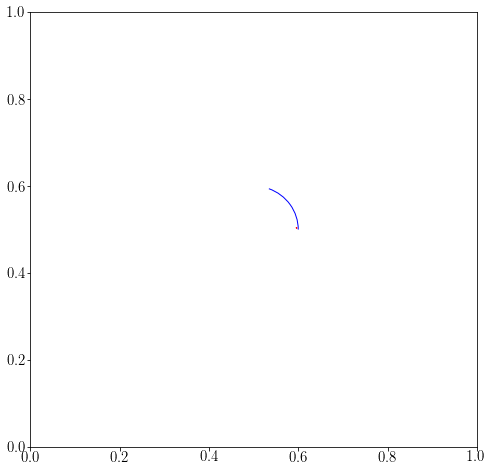

In [190]:
fig, ax1 = plt.subplots(1, 1, figsize = (8, 8))
arc = mpl.patches.Arc((0.5,0.5), 0.2, 0.2, 0, theta1 = 0, theta2=70, color='blue')
ax1.add_patch(arc)
fancy = FancyArrowPatch((0.6, 0.5), (0.5, 0.6), patchB=arc, color='red')
ax1.add_patch(fancy)

-0.026089680568739865
-1549.5750181842027


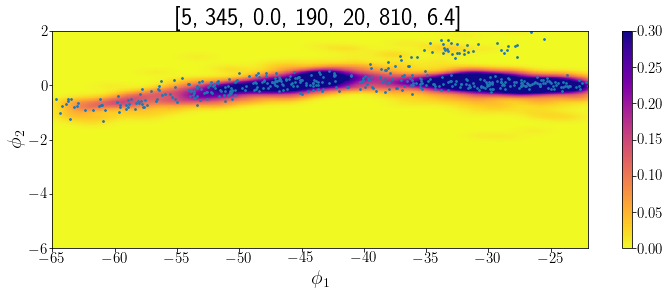

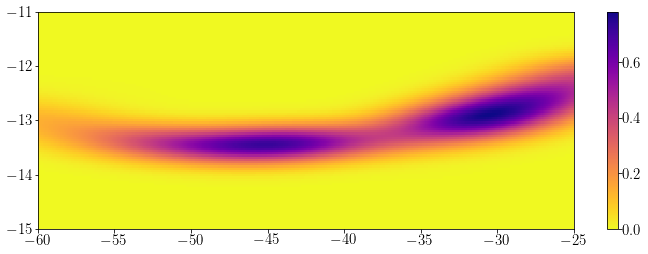

In [886]:
vals = [5, 345, 0.0, 190, 20, 810, 6.4]
ll, kde_phi2, kde_pm1, kde_pm2, kde_rv = fitpert.loglik_model_kde(vals)
#current, orbits = fitpert.nbody()
print(ll)

X, Y = np.meshgrid(np.linspace(-65, -22, 500), np.linspace(-6, 2,500))
sc = kde_phi2.score_samples(np.array([(X.flatten())/10, Y.flatten()]).T).reshape(500, 500)
plt.figure(figsize=(12,4))
plt.pcolormesh(X, Y, np.e**sc, cmap='plasma_r', vmax=0.3)
plt.colorbar()
datap = model_output[(model_output.phi1[:,0] > -65) & (model_output.phi1[:,0] < -22)]
plt.scatter(datap.phi1, datap.phi2, s=3, alpha=1)
plt.xlabel(r'$\phi_1$')
plt.ylabel(r'$\phi_2$')
plt.title(str(vals))

X, Y = np.meshgrid(np.linspace(-60, -25, 500), np.linspace(-15, -11,100))
sc = kde_pm1.score_samples(np.array([(X.flatten())/15, Y.flatten()]).T).reshape(100, 500)
plt.figure(figsize=(12,4))
plt.pcolormesh(X, Y, np.e**sc, cmap='plasma_r')
plt.colorbar()
datap = model_output[(model_output.phi1[:,0] > -60) & (model_output.phi1[:,0] < -25)]
#plt.scatter(datap.phi1, datap.pm1, s=10, alpha=1)
plt.show()

In [808]:
importlib.reload(fp)

fitpert = fp.FitPert()

for i in np.arange(0, 360, 45):
    print(i)
    vals = [1, i, 0.4, 80, 160, 400, 6.3]
    ll, kde_phi2, kde_pm1, kde_pm2, kde_rv = fitpert.loglik_model_kde(vals)
    #current, orbits = fitpert.nbody()
    print(ll)

    X, Y = np.meshgrid(np.linspace(-65, -22, 500), np.linspace(-6, 2,500))
    sc = kde_phi2.score_samples(np.array([(X.flatten())/10, Y.flatten()]).T).reshape(500, 500)
    plt.figure(figsize=(12,4))
    plt.pcolormesh(X, Y, np.e**sc, cmap='plasma_r')
    plt.colorbar()
    datap = model_output[(model_output.phi1[:,0] > -65) & (model_output.phi1[:,0] < -22)]
    plt.scatter(datap.phi1, datap.phi2, s=3, alpha=1)
    plt.xlabel(r'$\phi_1$')
    plt.ylabel(r'$\phi_2$')
    plt.title(str(vals))
    
    X, Y = np.meshgrid(np.linspace(-60, -25, 500), np.linspace(-15, -11,100))
    sc = kde_pm1.score_samples(np.array([(X.flatten())/15, Y.flatten()]).T).reshape(100, 500)
    plt.figure(figsize=(12,4))
    plt.pcolormesh(X, Y, np.e**sc, cmap='plasma_r')
    plt.colorbar()
    datap = model_output[(model_output.phi1[:,0] > -60) & (model_output.phi1[:,0] < -25)]
    plt.scatter(datap.phi1, datap.pm1, s=10, alpha=1)
    plt.show()

0
-0.05726196874344898


KeyboardInterrupt: 